## Overview

Your goal is to implement the KLT tracking tracking algorithm. Write your code without using OpenCV functions, except for a few that are indicated in the instructions below. Approved OpenCV functions tend to be for low-level operations such as file I/O, image format manipulation (e.g., color/grayscale conversion), and highlighting image locations by drawing geometric shapes (e.g., circles). Basic math functions from Python/NumPy are also allowed.

# Environment setup

In [1]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Change the directory to your own working directory
# Any files under your working directory are available to your code
# TO DO: enter the name of your directory
import os
os.chdir('/content/drive/MyDrive/path_to_directory')

In [3]:
# Import library modules
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
# PIL is the Python Imaging Library
from PIL import Image  
# The following is a substitute for cv2.imshow, which Colab does not allow
from google.colab.patches import cv2_imshow

print('Python version:', sys.version)
print('OpenCV version:', cv2.__version__)
print('NumPy version: ', np.__version__)


Python version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
OpenCV version: 4.1.2
NumPy version:  1.19.5


#Getting started

The "hotel" image sequence is a set of 51 images: `hotel.seq00.png`, ..., `hotel.seq50.png`. If you display them in quick succession you will see a toy hotel undergo rotation and a small amount of translation. Keep these files inside the folder `hotel_images`, and upload that folder to your working directory at Colab.

Use the following code block to verify a correct upload, and to illustrate keypoint detection. This example finds Shi-Tomasi feature points in image 0 of the sequence, and indicates their locations by small green circles. 

Number of detected keypoints = 161


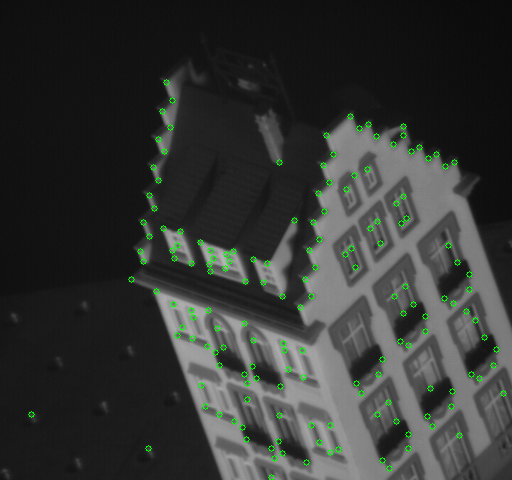

In [4]:
# The purpose of this code block is to verify that you can access the hotel 
#  images, and to illustrate examples of keypoints.
# Parts of this example were borrowed from 
#  https://docs.opencv.org/4.x/d4/d8c/tutorial_py_shi_tomasi.html

DISPLAY_RADIUS = 3
DISPLAY_COLOR  = (0, 255, 0)

def keypointDetectionDemo(im0):
  # find image locations that may be good for tracking
  feature_params = dict( maxCorners = 300,
                       qualityLevel = 0.2, 
                       minDistance = 7,  
                       blockSize = 5 )     
  p0 = cv2.goodFeaturesToTrack(im0, mask = None, **feature_params)
  # now corners should contain an array of (floating point) pixel locations 
  if p0 is None:
    print("no keypoints were found!")
    return
  print (f'Number of detected keypoints = {p0.shape[0]}')

  # convert to kx2 format, where k is the number of feature points
  corners = np.zeros((p0.shape[0],2))
  for i in range(corners.shape[0]):
    corners[i] = p0[i][0]

  # draw a small circle at each detected point and display the result
  im0color = cv2.cvtColor(im0, cv2.COLOR_GRAY2BGR)
  cornersInt = np.intp(np.round(corners)) # convert to integers used for indexing 
  for i in cornersInt:
    x, y = i.ravel()      # returns a contiguous flattened array
    cv2.circle(im0color, (x, y), DISPLAY_RADIUS, DISPLAY_COLOR)

  cv2_imshow(im0color)
  return
  
# load and display a sample image, detect features, and display the results
im0 = cv2.imread("hotel_images/hotel.seq00.png", cv2.COLOR_BGR2GRAY)
keypointDetectionDemo(im0)


# Tracking

Apply the Kanade-Lucas-Tomasi tracking procedure to track the keypoints that were detected in the previous code example. Those keypoints were detected in image 0 of the hotel sequence, and the goal is to track them throughout images 1 to 50.

The KLT procedure operates on a pair of images that were captured at times t and t+1. For a given keypoint at (x, y) at time t, the procedure tries to find the new location (x', y') of the same keypoint at time t+1.  For reference, the following pseudocode is from the lecture slides.  
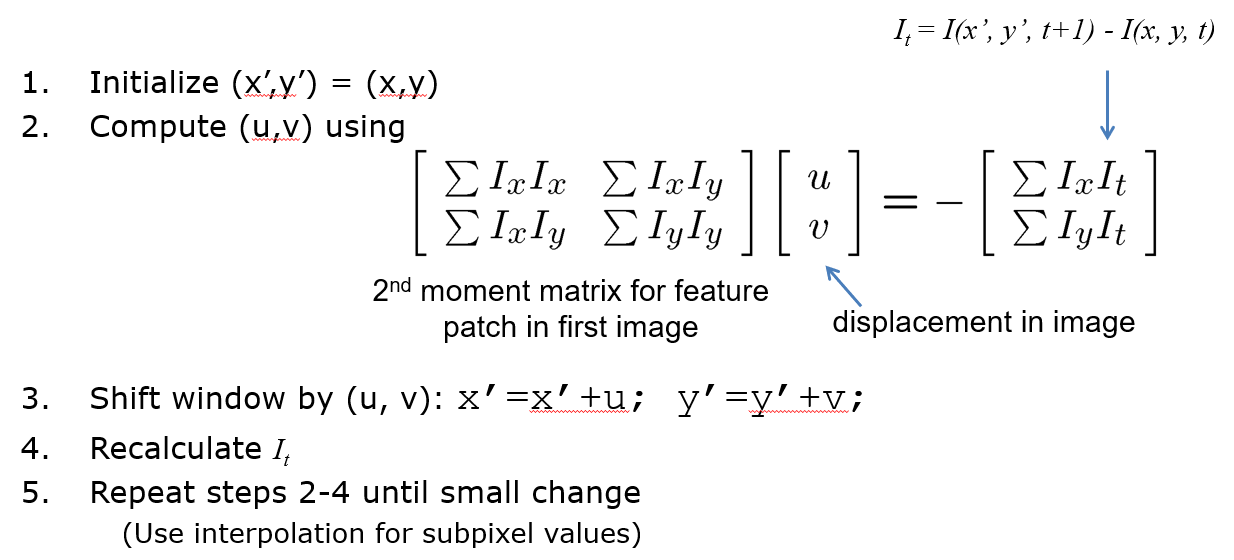


The KLT tracking procedure assumes small movements of keypoints from t to t+1. For this reason, tracking needs to be performed at subpixel resolution. Keypoint locations therefore need to be maintained using floating point values. 

The matrix equation depends on spatial gradients, which can be noisy. For this reason, you should perform smoothing of the spatial gradients when computing these matrices.

You *are* allowed to use the OpenCV function `getRectSubPix`, which takes an image location at subpixel resolution, and interpolates neighboring pixel values to return a small region of interest from the image. For computing the summations in the pseudocode, it is suggested that you use a window size of 15x15 surrounding the keypoint. Some useful functions here are `np.sum`, `np.multiply`, etc. 




The first function that you should implement is **`getNextPoints`** in the next code block. It should apply the KLT procedure using a pair of images for a given collection of feature points. For each feature point in an image at time t, the procedure tries to find the location of the corresponding point in an image at time t+1.

It is likely that some of the keypoints will eventually move out of the image frame as they are tracked over the entire sequence. To handle these situations in a simple way, it is suggested that you maintain a `movedOutFlag` vector of True/False values. If an element in `movedOutFlag` is False, then the associated keypoint is inside the image frame and should be processed; but if True, then `getNextPoints` should ignore that keypoint.

In [5]:
def linear_filter(img_in, kernel):
      runrow = len(img_in)-len(kernel)+1
      runcol = len(img_in[0])-len(kernel)+1
      img_out = np.zeros((len(img_in), len(img_in[0])), dtype=np.float32)
      for i in range(runrow):
        for j in range(runcol):
          img_out[i+(len(kernel)//2),j+(len(kernel)//2)] = min(255, np.sum(abs(img_in[i:i+len(kernel),j:j+len(kernel)])*kernel))
      return img_out


def getNextPoints(im1, im2, xy, movedOutFlag):
    '''Track keypoints from image im1 to image im2
     Input:
      im1: grayscale image at time t; shape (m, n)
      im2: grayscale image at time t+1; shape (m, n)
      xy:  a numpy array of size kx2, where k is the number of keypoints
       Each keypoint is of the form [x, y], with both in floating-point format
     Output:
      xy2: updated keypoint locations; same format as xy input 
      movedOutFlag: array of True/False values, of size kx1, 
       to indicate whether each associated
       keypoint has moved outside the dimensions of the image array

     TO DO: Implement the getNextPoints function.
  '''
    print("In function getNextPoints")
    kernel = np.array([[1, 4, 7, 4, 1],
                  [4, 16, 26, 16, 4],
                  [7, 26, 41, 26, 7],
                  [4, 16, 26, 16, 4],
                  [1, 4, 7, 4, 1,]], dtype=np.float32) / 273.0
    im1 = linear_filter(im1, kernel)
    im2 = linear_filter(im2, kernel)
    im1y, im1x = np.gradient(im1)


    xy2 = np.copy(xy)
    for i in range(len(xy)):
      if movedOutFlag[i] == 0:
        img1x = cv2.getRectSubPix(im1x, (15, 15), tuple(xy[i]))
        img1y = cv2.getRectSubPix(im1y, (15, 15), tuple(xy[i]))
        img1 = cv2.getRectSubPix(im1, (15, 15), tuple(xy[i]))
        img2 = cv2.getRectSubPix(im2, (15, 15), tuple(xy2[i]))
        It = img2 - img1
        Invmat = np.array([[np.sum(np.multiply(img1x,img1x)), np.sum(np.multiply(img1x,img1y))], [np.sum(np.multiply(img1x,img1y)), np.sum(np.multiply(img1y,img1y))]])
        Rhsmat = -np.array([[np.sum(np.multiply(img1x,It))], [np.sum(np.multiply(img1y,It))]])

        uv = np.matmul(np.linalg.inv(Invmat), Rhsmat)

        xy2[i] = [xy2[i][0]+uv[0][0], xy2[i][1]+uv[1][0]]
        if xy2[i][0]>=im2.shape[1] or xy2[i][1]>=im2.shape[0] or 0 >= xy2[i][1] or 0 >= xy2[i][0]:
          movedOutFlag[i] = 1


    
    return ( xy2, movedOutFlag )



In order to generate and see your final KLT tracking results write the code so that it automatically displays the following:

*   images showing tracked keypoint locations for t=1 and t=11 and t=50, and possibly for a few more values of t (but do not display all of the images in your final output)
*   at the end, display image 0 that has been updated to show 2D paths that were taken by each keypoint during tracking (an example is given later)

In [7]:
# KLT TRACKING - main code block

# global variables - try to write you code without needing additional globals
NUMBER_OF_IMAGES = 51  # try smaller values here for initial testing
DISPLAY_RADIUS = 3
GREEN = (0, 255, 0)
YELLOW = (0, 255, 255)

def mainFunction():
  '''This is the main "driver" function that performs KLT tracking
  '''
  print("In mainFunction")
  allImgs = readImages(NUMBER_OF_IMAGES)
  print (f'number of images that were read = {len(allImgs)}')

  # get initial keypoints from image 0
  image0 = allImgs[0]
  xy = getKeypoints(image0)
  if xy is None:
    print("no points to track!")
    return
  print (f'number of detected keypoints = {xy.shape[0]}')

  # display keypoints for image 0
  image0color = cv2.cvtColor(image0, cv2.COLOR_GRAY2BGR)
  corners = np.intp(np.round(xy))  
  for i in corners:
    x, y = i.ravel()
    cv2.circle(image0color, (x, y), DISPLAY_RADIUS, GREEN)

  # track the initial keypoints through all remaining images
  xyt = trackPoints(xy, allImgs)

  # in image 0, draw the paths taken by the keypoints 
  drawPaths(image0color, xyt)
  return


def readImages(filecount):
  '''Read a sequence of image files, starting with image 0 in 'hotel' sequence
     Input:
      filecount: how many image files to read
     Output:
      allImages: a list of OpenCV images in sequential order 
  '''
  print("In function readImages")
  allImages = []
  for i in range(filecount):
    print (f'reading image {i:02}')
    imagetmp = cv2.imread("hotel_images/hotel.seq" + f'{i:02d}' + ".png", cv2.COLOR_BGR2GRAY)
    allImages.append(imagetmp)
  return allImages


def getKeypoints(im0):
  '''Find keypoints that will be good for tracking;
     you are allowed to copy code directly from keypointDetectionDemo
     Input:
      im0: grayscale source image with shape (m, n)
     Output:
      corners: a numpy array of size kx2, where k is the number of keypoints. 
       Each keypoint is of the form [x, y], where x and y are floating-point
       values that represent image locations in the (horizontal, vertical) 
       directions, respectively. 

     TO DO: Implement the getKeypoints function.
  '''
  print ("In function getKeypoints")
  feature_params = dict( maxCorners = 300,
                       qualityLevel = 0.2, 
                       minDistance = 7,  
                       blockSize = 5 )     
  p0 = cv2.goodFeaturesToTrack(im0, mask = None, **feature_params)
  if p0 is None:
    print("no keypoints were found!")
    return
  print (f'Number of detected keypoints = {p0.shape[0]}')

  corners = np.zeros((p0.shape[0],2))
  for i in range(corners.shape[0]):
    corners[i] = p0[i][0]

  return corners
  

def trackPoints(xy, imageSequence):
  '''Track keypoints through the given image sequence
     Input:
      xy: a numpy array containing keypoints for the first image in imageSequence;
       format is identical to 'corners' in getKeypoints
      imageSequence: a list of OpenCV images in sequential order
     Output:
      xyt: <any format that you see fit, as needed by the drawPaths function>

     TO DO: Update the trackPoints function
  '''
  print ("In function trackPoints")
  print (f'length of imageSequence = {len(imageSequence)}')
  movedOutFlag = np.zeros(xy.shape[0])
  # initialize xyt to contain any information that is needed for drawing paths at the end of tracking
  # also add code in this function as needed to maintain xyt
  xyt = [list(xy)]

  for t in range(0, len(imageSequence)-1): # predict for all images except first in sequence
    print (f't = {t}; predicting for t = {t+1}') 
    xy2, movedOutFlag = getNextPoints(imageSequence[t], imageSequence[t+1], xy, movedOutFlag)
    xy = xy2
    xyt.extend([list(xy)])

    # for selected instants in time, display the latest image with highlighted keypoints 
    if ((t == 0) or (t == 10) or (t == 20) or (t == 30) or (t == 40) or (t == 49)):
      im2color = cv2.cvtColor(imageSequence[t+1], cv2.COLOR_GRAY2BGR)
      corners = np.intp(np.round(xy2))  
      for c in range(0, corners.shape[0]):
        if movedOutFlag[c] == False:
          x = corners[c][0]
          y = corners[c][1]
          cv2.circle(im2color, (x, y), DISPLAY_RADIUS, GREEN)
      cv2_imshow(im2color)
    
  return xyt

def drawPaths(im0color, xyt):
  '''In the given image, draw paths that were taken by each keypoint during tracking
     Input:
      im0color: a color image with shape (m, n, 3), typically the first image in a sequence
     Output:
      xyt: <any format that you see fit, as needed for drawing the paths>

     TO DO: Implement the drawPaths function
  '''
  print ("In function drawPaths")
  for i in range(1, len(xyt)):
    for j in range(len(xyt[i])):
      x0 = int(tuple(xyt[i-1][j])[0])
      y0 = int(tuple(xyt[i-1][j])[1])
      x1 = int(tuple(xyt[i][j])[0])
      y1 = int(tuple(xyt[i][j])[1])
      im0color = cv2.line(im0color, (x0,y0), (x1,y1), YELLOW, thickness=1)



  print ("FINISHED: here are the paths of the tracked keypoints")
  cv2_imshow(im0color)



In mainFunction
In function readImages
reading image 00
reading image 01
reading image 02
reading image 03
reading image 04
reading image 05
reading image 06
reading image 07
reading image 08
reading image 09
reading image 10
reading image 11
reading image 12
reading image 13
reading image 14
reading image 15
reading image 16
reading image 17
reading image 18
reading image 19
reading image 20
reading image 21
reading image 22
reading image 23
reading image 24
reading image 25
reading image 26
reading image 27
reading image 28
reading image 29
reading image 30
reading image 31
reading image 32
reading image 33
reading image 34
reading image 35
reading image 36
reading image 37
reading image 38
reading image 39
reading image 40
reading image 41
reading image 42
reading image 43
reading image 44
reading image 45
reading image 46
reading image 47
reading image 48
reading image 49
reading image 50
number of images that were read = 51
In function getKeypoints
Number of detected keypoints = 1

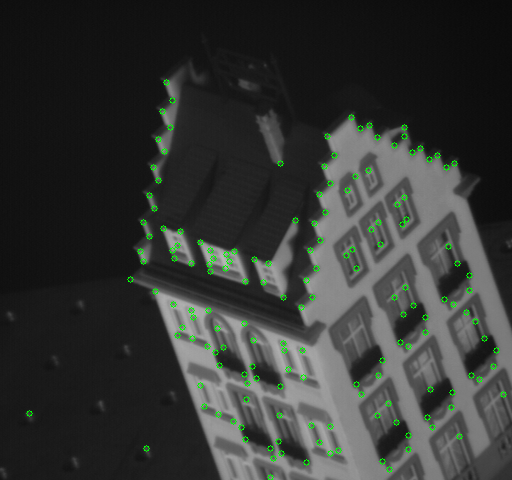

t = 1; predicting for t = 2
In function getNextPoints
t = 2; predicting for t = 3
In function getNextPoints
t = 3; predicting for t = 4
In function getNextPoints
t = 4; predicting for t = 5
In function getNextPoints
t = 5; predicting for t = 6
In function getNextPoints
t = 6; predicting for t = 7
In function getNextPoints
t = 7; predicting for t = 8
In function getNextPoints
t = 8; predicting for t = 9
In function getNextPoints
t = 9; predicting for t = 10
In function getNextPoints
t = 10; predicting for t = 11
In function getNextPoints


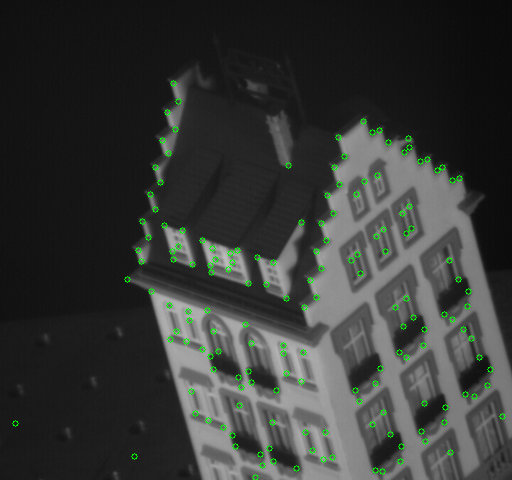

t = 11; predicting for t = 12
In function getNextPoints
t = 12; predicting for t = 13
In function getNextPoints
t = 13; predicting for t = 14
In function getNextPoints
t = 14; predicting for t = 15
In function getNextPoints
t = 15; predicting for t = 16
In function getNextPoints
t = 16; predicting for t = 17
In function getNextPoints
t = 17; predicting for t = 18
In function getNextPoints
t = 18; predicting for t = 19
In function getNextPoints
t = 19; predicting for t = 20
In function getNextPoints
t = 20; predicting for t = 21
In function getNextPoints


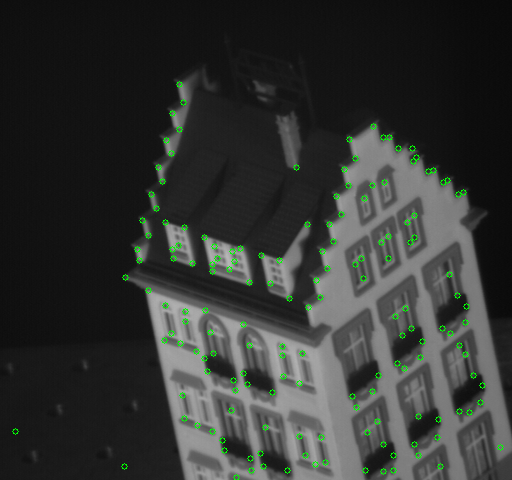

t = 21; predicting for t = 22
In function getNextPoints
t = 22; predicting for t = 23
In function getNextPoints
t = 23; predicting for t = 24
In function getNextPoints
t = 24; predicting for t = 25
In function getNextPoints
t = 25; predicting for t = 26
In function getNextPoints
t = 26; predicting for t = 27
In function getNextPoints
t = 27; predicting for t = 28
In function getNextPoints
t = 28; predicting for t = 29
In function getNextPoints
t = 29; predicting for t = 30
In function getNextPoints
t = 30; predicting for t = 31
In function getNextPoints


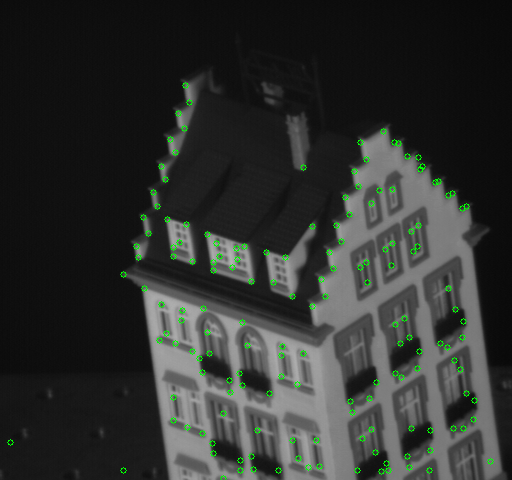

t = 31; predicting for t = 32
In function getNextPoints
t = 32; predicting for t = 33
In function getNextPoints
t = 33; predicting for t = 34
In function getNextPoints
t = 34; predicting for t = 35
In function getNextPoints
t = 35; predicting for t = 36
In function getNextPoints
t = 36; predicting for t = 37
In function getNextPoints
t = 37; predicting for t = 38
In function getNextPoints
t = 38; predicting for t = 39
In function getNextPoints
t = 39; predicting for t = 40
In function getNextPoints
t = 40; predicting for t = 41
In function getNextPoints


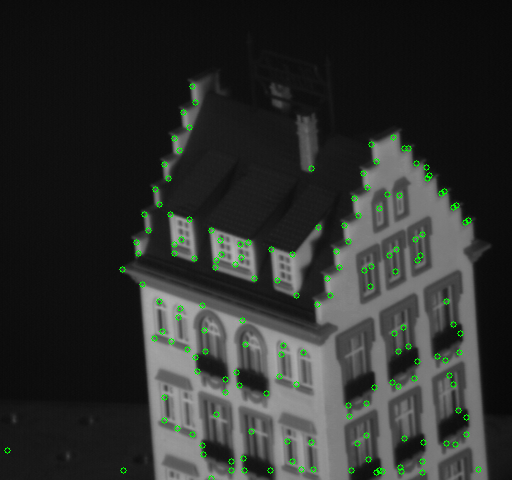

t = 41; predicting for t = 42
In function getNextPoints
t = 42; predicting for t = 43
In function getNextPoints
t = 43; predicting for t = 44
In function getNextPoints
t = 44; predicting for t = 45
In function getNextPoints
t = 45; predicting for t = 46
In function getNextPoints
t = 46; predicting for t = 47
In function getNextPoints
t = 47; predicting for t = 48
In function getNextPoints
t = 48; predicting for t = 49
In function getNextPoints
t = 49; predicting for t = 50
In function getNextPoints


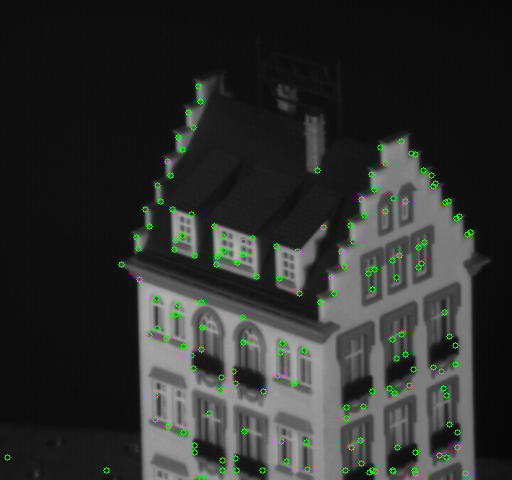

In function drawPaths
FINISHED: here are the paths of the tracked keypoints


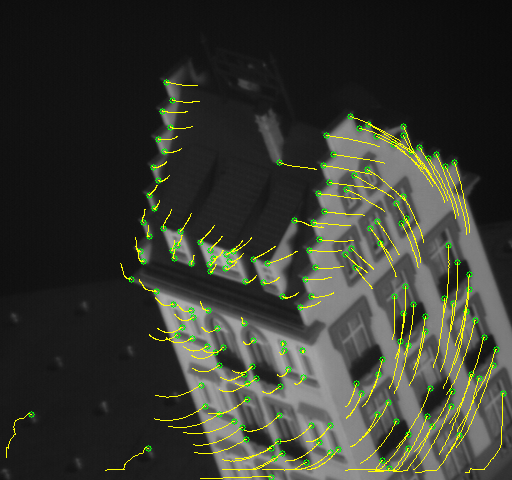

In [8]:
# Run the KLT tracking code
mainFunction()

Here is an example output from `drawPaths`. With close examination, you can see that it is not perfect for all keypoints. It is okay if your result is not perfect, either. (But try to make your output at least this good.)



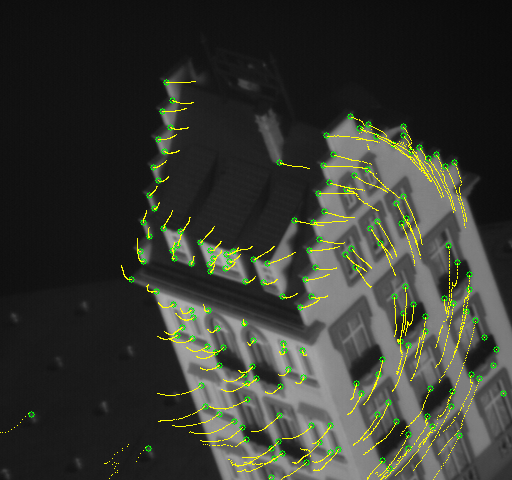



## With Harris Corner Detection
I am using the same rest of the procedure and just changing the getKeypoints function. I am using Harris Corner Detection method to compute the function and using the window size of 5, k as 0.06 and getting approx a bit more than 100 keypoints. The threshold value of r which works the best for me is 1000000 as it helps me in getting the number of keypoints detected around 100.

In mainFunction
In function readImages
reading image 00
reading image 01
reading image 02
reading image 03
reading image 04
reading image 05
reading image 06
reading image 07
reading image 08
reading image 09
reading image 10
reading image 11
reading image 12
reading image 13
reading image 14
reading image 15
reading image 16
reading image 17
reading image 18
reading image 19
reading image 20
reading image 21
reading image 22
reading image 23
reading image 24
reading image 25
reading image 26
reading image 27
reading image 28
reading image 29
reading image 30
reading image 31
reading image 32
reading image 33
reading image 34
reading image 35
reading image 36
reading image 37
reading image 38
reading image 39
reading image 40
reading image 41
reading image 42
reading image 43
reading image 44
reading image 45
reading image 46
reading image 47
reading image 48
reading image 49
reading image 50
number of images that were read = 51
In function getKeypoints
number of detected keypoints = 1

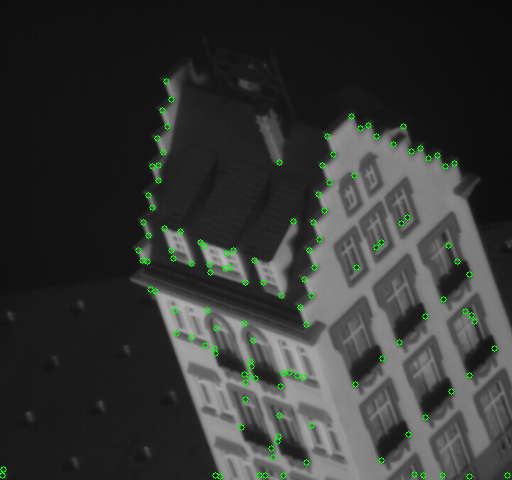

t = 1; predicting for t = 2
In function getNextPoints
t = 2; predicting for t = 3
In function getNextPoints
t = 3; predicting for t = 4
In function getNextPoints
t = 4; predicting for t = 5
In function getNextPoints
t = 5; predicting for t = 6
In function getNextPoints
t = 6; predicting for t = 7
In function getNextPoints
t = 7; predicting for t = 8
In function getNextPoints
t = 8; predicting for t = 9
In function getNextPoints
t = 9; predicting for t = 10
In function getNextPoints
t = 10; predicting for t = 11
In function getNextPoints


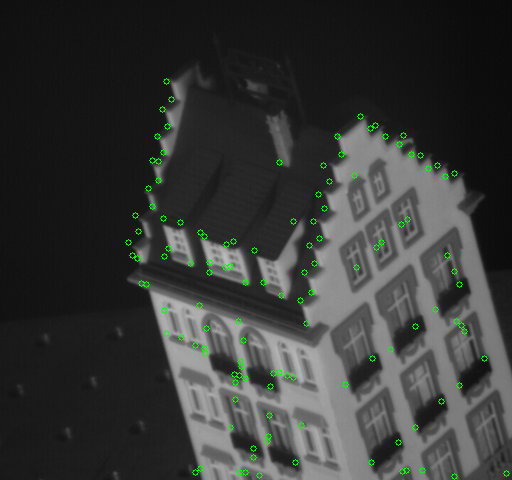

t = 11; predicting for t = 12
In function getNextPoints
t = 12; predicting for t = 13
In function getNextPoints
t = 13; predicting for t = 14
In function getNextPoints
t = 14; predicting for t = 15
In function getNextPoints
t = 15; predicting for t = 16
In function getNextPoints
t = 16; predicting for t = 17
In function getNextPoints
t = 17; predicting for t = 18
In function getNextPoints
t = 18; predicting for t = 19
In function getNextPoints
t = 19; predicting for t = 20
In function getNextPoints
t = 20; predicting for t = 21
In function getNextPoints


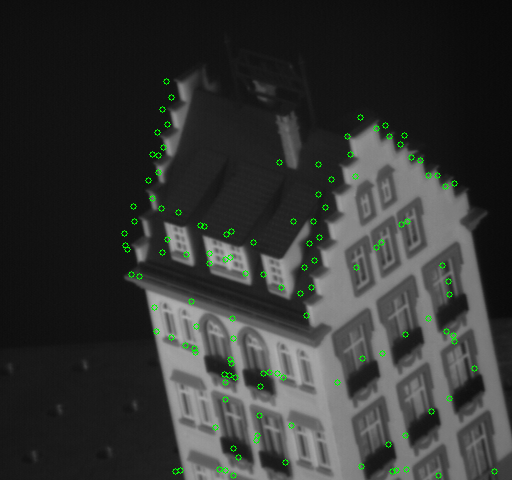

t = 21; predicting for t = 22
In function getNextPoints
t = 22; predicting for t = 23
In function getNextPoints
t = 23; predicting for t = 24
In function getNextPoints
t = 24; predicting for t = 25
In function getNextPoints
t = 25; predicting for t = 26
In function getNextPoints
t = 26; predicting for t = 27
In function getNextPoints
t = 27; predicting for t = 28
In function getNextPoints
t = 28; predicting for t = 29
In function getNextPoints
t = 29; predicting for t = 30
In function getNextPoints
t = 30; predicting for t = 31
In function getNextPoints


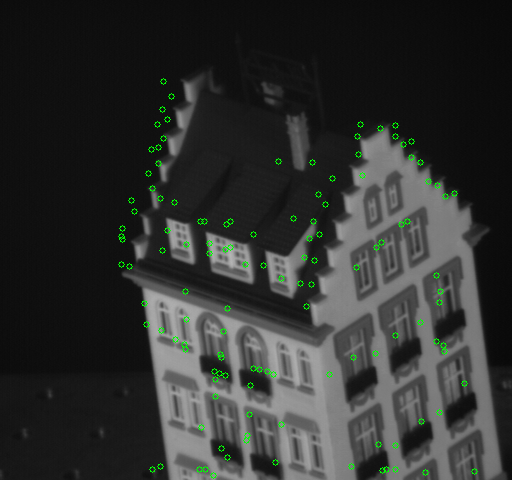

t = 31; predicting for t = 32
In function getNextPoints
t = 32; predicting for t = 33
In function getNextPoints
t = 33; predicting for t = 34
In function getNextPoints
t = 34; predicting for t = 35
In function getNextPoints
t = 35; predicting for t = 36
In function getNextPoints
t = 36; predicting for t = 37
In function getNextPoints
t = 37; predicting for t = 38
In function getNextPoints
t = 38; predicting for t = 39
In function getNextPoints
t = 39; predicting for t = 40
In function getNextPoints
t = 40; predicting for t = 41
In function getNextPoints


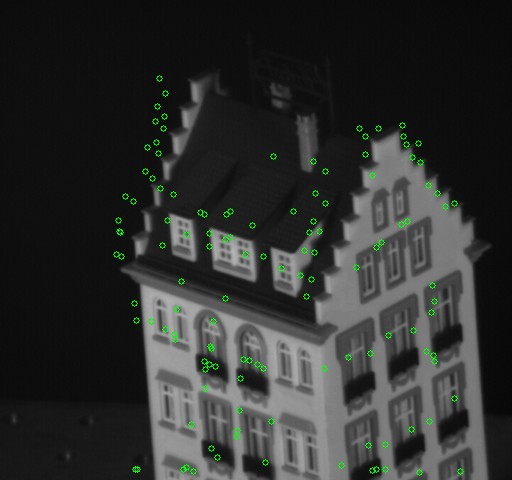

t = 41; predicting for t = 42
In function getNextPoints
t = 42; predicting for t = 43
In function getNextPoints
t = 43; predicting for t = 44
In function getNextPoints
t = 44; predicting for t = 45
In function getNextPoints
t = 45; predicting for t = 46
In function getNextPoints
t = 46; predicting for t = 47
In function getNextPoints
t = 47; predicting for t = 48
In function getNextPoints
t = 48; predicting for t = 49
In function getNextPoints
t = 49; predicting for t = 50
In function getNextPoints


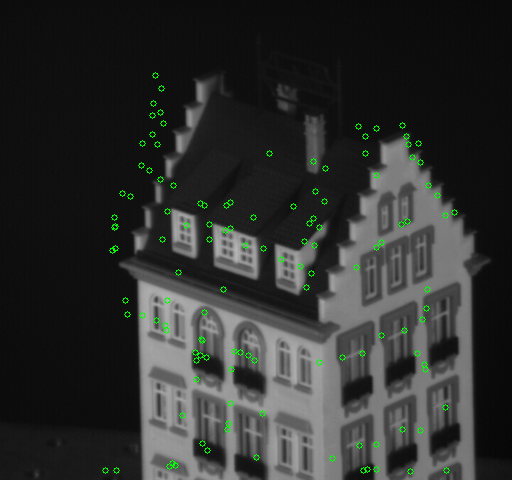

In function drawPaths
FINISHED: here are the paths of the tracked keypoints


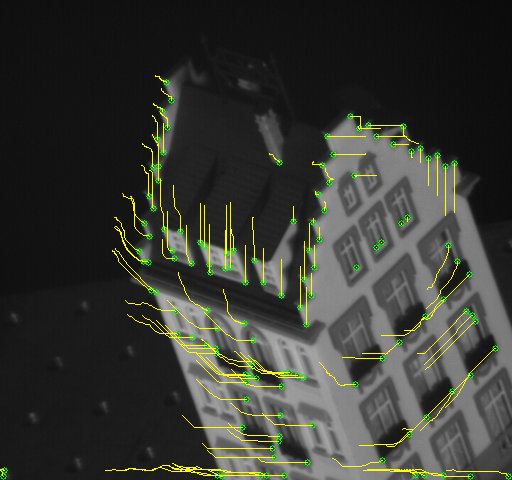

In [9]:
def linear_filter(img_in, kernel):
      runrow = len(img_in)-len(kernel)+1
      runcol = len(img_in[0])-len(kernel)+1
      img_out = np.zeros((len(img_in), len(img_in[0])), dtype=np.float32)
      for i in range(runrow):
        for j in range(runcol):
          img_out[i+(len(kernel)//2),j+(len(kernel)//2)] = min(255, np.sum(abs(img_in[i:i+len(kernel),j:j+len(kernel)])*kernel))
      return img_out

def getKeypoints(im0):

  print ("In function getKeypoints")
  kernel = np.array([[1, 4, 7, 4, 1],
              [4, 16, 26, 16, 4],
              [7, 26, 41, 26, 7],
              [4, 16, 26, 16, 4],
              [1, 4, 7, 4, 1,]], dtype=np.float32) / 273.0

  im0 = linear_filter(im0, kernel)
  I_y, I_x = np.gradient(im0)

  Ixx = I_x*I_x
  Ixy = I_x*I_y
  Iyy = I_y*I_y  

  # Ixx = linear_filter(I_x**2, kernel)
  # Ixy = linear_filter(I_x*I_y, kernel)
  # Iyy = linear_filter(I_y**2, kernel)

  k = 0.06 #My value for k[0.01, 0.06]

  height, width = im0.shape
  cornerList = [] # List with all the corners including the repetative ones
  corners = [] #The final list of corners to be passed-on with repetative corners
  window_size = 5 #Variable for window size (5x5) in this case
  offset = window_size//2
  for y in range(offset, height-offset):
      for x in range(offset, width-offset):
          Sxx = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
          Syy = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
          Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])
          
          det = (Sxx * Syy) - (Sxy**2)
          trace = Sxx + Syy
          r = det - k*(trace**2)
          
          if r > 1000000: #The threshold value for r that I am using is 1000000
            cornerList.append([r, x, y, 0])

  cornerList.sort(reverse=True)

  for i in cornerList:
      if i[3] != 1:
          for j in cornerList:
              if j[3] != 1:
                  dist = np.sqrt((j[1] - i[1])**2 + (j[2] - i[2])**2)
                  if (dist <= window_size and dist > 0):
                      j[3] = 1
  for i in cornerList:
    if i[3] == 0:
      corners.append([i[1], i[2]])

  corners = np.array(corners)

  return corners

mainFunction()

---
# Creating a HTML version of your current notebook

In [ ]:
# TO DO: Provide the full path to your Jupyter notebook file
!jupyter nbconvert --to html "/content/drive/MyDrive/path_to.ipynb"